   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 41.5 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Fish-disease-classification-1 in folder:: 100%|██████████| 1210/1210 [00:00<00:00, 4985.63it/s]


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 1095 images belonging to 7 classes.
Found 44 images belonging to 7 classes.
Found 45 images belonging to 7 classes.


Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


Epoch 1/10
35/35 - 37s - 1s/step - accuracy: 0.3900 - loss: 1.8037 - val_accuracy: 0.4318 - val_loss: 1.5282
Epoch 2/10
35/35 - 16s - 444ms/step - accuracy: 0.6539 - loss: 1.1297 - val_accuracy: 0.5455 - val_loss: 1.2286
Epoch 3/10
35/35 - 14s - 398ms/step - accuracy: 0.7498 - loss: 0.8014 - val_accuracy: 0.6591 - val_loss: 0.9620
Epoch 4/10
35/35 - 14s - 395ms/step - accuracy: 0.8256 - loss: 0.6246 - val_accuracy: 0.7273 - val_loss: 0.8656
Epoch 5/10
35/35 - 14s - 397ms/step - accuracy: 0.8612 - loss: 0.4966 - val_accuracy: 0.7273 - val_loss: 0.7695
Epoch 6/10
35/35 - 14s - 398ms/step - accuracy: 0.8913 - loss: 0.3838 - val_accuracy: 0.8409 - val_loss: 0.6680
Epoch 7/10
35/35 - 14s - 407ms/step - accuracy: 0.9260 - loss: 0.3033 - val_accuracy: 0.8864 - val_loss: 0.6234
Epoch 8/10
35/35 - 20s - 574ms/step - accuracy: 0.9324 - loss: 0.2769 - val_accuracy: 0.8409 - val_loss: 0.6183
Epoch 9/10
35/35 - 14s - 401ms/step - accuracy: 0.9434 - loss: 0.2295 - val_accuracy: 0.8409 - val_loss: 0.

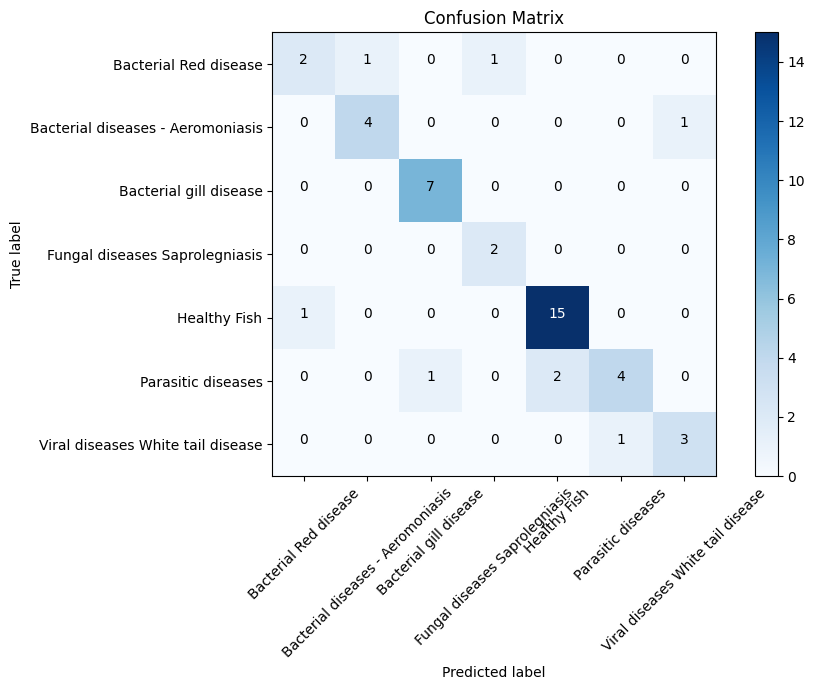

In [ ]:
# Étape 1: Téléchargement du dataset
!pip install roboflow
from roboflow import Roboflow
rf = Roboflow(api_key="****************")
project = rf.workspace("**************").project("fish-disease-classification")
version = project.version(1)
dataset = version.download("folder")

# Étape 2: Chargement du modèle MobileNet pré-entraîné
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

mobile = tf.keras.applications.mobilenet.MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Étape 3: Modifications du modèle pour ton dataset
x = mobile.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(7, activation='softmax')(x)

model = Model(inputs=mobile.input, outputs=output)

# Dégeler quelques couches (pas toutes) pour réduire le temps d'entraînement
for layer in model.layers[:-20]:  # moins de couches dégélées
    layer.trainable = False

# Étape 4: Compilation
model.compile(optimizer=Adam(learning_rate=0.00005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Étape 5: Augmentation des données
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_batches = train_datagen.flow_from_directory(
    dataset.location + '/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

valid_batches = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255).flow_from_directory(
    dataset.location + '/valid',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_batches = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255).flow_from_directory(
    dataset.location + '/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Calcul des poids des classes
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(test_batches.classes),
    y=test_batches.classes
)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Ajout d'un EarlyStopping pour éviter l'entraînement inutile
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entraînement du modèle (réduit à 10 époques)
model.fit(
    train_batches,
    validation_data=valid_batches,
    epochs=10,
    class_weight=class_weights_dict,
    verbose=2,
    callbacks=[early_stop]
)

# Évaluation et matrice de confusion
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

test_labels = test_batches.classes
predictions = model.predict(test_batches, verbose=0)
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

cm_plot_labels = [
    'Bacterial Red disease', 'Bacterial diseases - Aeromoniasis',
    'Bacterial gill disease', 'Fungal diseases Saprolegniasis',
    'Healthy Fish', 'Parasitic diseases', 'Viral diseases White tail disease'
]

plot_confusion_matrix(cm, cm_plot_labels)


In [11]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Redéfinir les labels si nécessaire
cm_plot_labels = [
    'Bacterial Red disease',
    'Bacterial diseases - Aeromoniasis',
    'Bacterial gill disease',
    'Fungal diseases Saprolegniasis',
    'Healthy Fish',
    'Parasitic diseases',
    'Viral diseases White tail disease'
]

# Charger et prétraiter l'image
img_path = '1000_F_507797256_NCOU5WxyKHSRHpefhMS1yn6QCKP1gHUT.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Prédiction
prediction = model.predict(img_array)
predicted_label = cm_plot_labels[np.argmax(prediction)]

print(f"Classe prédite : {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Classe prédite : Bacterial Red disease


In [7]:
from sklearn.metrics import classification_report

# Générer le rapport de classification
report = classification_report(
    y_true=test_labels,
    y_pred=predictions.argmax(axis=1),
    target_names=cm_plot_labels
)

print(report)


                                   precision    recall  f1-score   support

            Bacterial Red disease       0.67      0.50      0.57         4
Bacterial diseases - Aeromoniasis       0.80      0.80      0.80         5
           Bacterial gill disease       0.88      1.00      0.93         7
   Fungal diseases Saprolegniasis       0.67      1.00      0.80         2
                     Healthy Fish       0.88      0.94      0.91        16
               Parasitic diseases       0.80      0.57      0.67         7
Viral diseases White tail disease       0.75      0.75      0.75         4

                         accuracy                           0.82        45
                        macro avg       0.78      0.79      0.78        45
                     weighted avg       0.82      0.82      0.81        45



In [12]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="u5nfd5Xk70hsg3V2uFQZ")
project = rf.workspace("med-amin-kh").project("fish-disease-classification-l7hrm")
version = project.version(1)
dataset = version.download("folder")


loading Roboflow workspace...
loading Roboflow project...


In [9]:
import os
from collections import Counter

# Remplace par ton chemin vers le dossier train/valid/test
base_dir = 'Fish-disease-classification-1/train'

# Dictionnaire pour stocker les comptes
class_counts = {}

for class_name in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_name)
    if os.path.isdir(class_path):
        num_images = len([
            f for f in os.listdir(class_path)
            if os.path.isfile(os.path.join(class_path, f))
        ])
        class_counts[class_name] = num_images

# Affichage
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")


Healthy Fish: 432 images
Bacterial diseases - Aeromoniasis: 117 images
Bacterial Red disease: 102 images
Fungal diseases Saprolegniasis: 120 images
Viral diseases White tail disease: 99 images
Bacterial gill disease: 135 images
Parasitic diseases: 90 images
